In [9]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

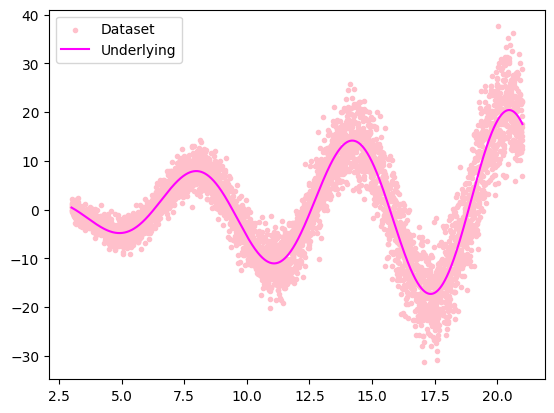

In [81]:
def f(x):
    return x * np.sin(x)

xMin = 3
xMax = 21
nSample = 5000

# input
x = np.linspace(xMin, xMax, nSample)
x_actual = np.linspace(xMin, xMax, nSample)
y_actual = f(x)

np.random.shuffle(x)

np.random.seed(17)
epsilon1 = np.random.normal(0.0, 0.3, nSample)
epsilon2 = np.random.normal(0.0, 0.3, nSample)

y = f(x) + epsilon1 + epsilon2 * x

plt.scatter(x, y, label = "Dataset", color = "pink", s = 9)
plt.plot(x_actual, y_actual, label = "Underlying", color = "magenta")
plt.legend()
plt.show()

X_train = x.reshape(-1, 1)
y_train = y.reshape(-1, 1)
X_test = np.arange(xMin, xMax, 0.01).reshape(-1, 1)

In [82]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(5000, 1)
(1800, 1)
(5000, 1)


In [83]:
class GradientBoostedTreesEnsembleRegressor(tf.keras.Model):
    def __init__(self, n_estimators=100, max_depth=3, dropout=0.1, random_state=42):
        super(GradientBoostedTreesEnsembleRegressor, self).__init__()
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.dropout = dropout
        self.random_state = random_state
        self.estimators = []
        self.seed = random_state

    def build_estimator(self, input_shape):
        model = tfdf.keras.GradientBoostedTreesModel(
            task=tfdf.keras.Task.REGRESSION,
            num_trees=self.n_estimators,
            max_depth=self.max_depth,
            validation_ratio=0.1
        )
        return model

    def call(self, inputs, training=True):
        predictions = []
        for estimator in self.estimators:
            # Enable dropout during inference for uncertainty estimation
            ensemble_predictions = []
            if training:  # Apply dropout during training
                for _ in range(self.n_estimators):
                    ensemble_predictions.append(estimator.predict(inputs, as_dict=True)['predictions'])
            else:  # Disable dropout during inference
                ensemble_predictions.append(estimator.predict(inputs, as_dict=True)['predictions'])
            ensemble_predictions = tf.stack(ensemble_predictions, axis=-1)
            predictions.append(tf.reduce_mean(ensemble_predictions, axis=-1))
        predictions = tf.stack(predictions, axis=0)
        mean_prediction = tf.reduce_mean(predictions, axis=0)
        variance_prediction = tf.math.reduce_std(predictions, axis=0)
        return mean_prediction, variance_prediction

    def fit(self, X, y):
        for seed in np.random.randint(0, 1000000, size=self.n_estimators):
            self.seed = seed
            model = self.build_estimator(X.shape)
            model.fit(x=X, y=y)
            self.estimators.append(model)

    def predict(self, X, n_samples=10):
        predictions = []
        for _ in range(n_samples):
            ensemble_predictions = []
            for model in self.estimators:
                # Enable dropout during inference for uncertainty estimation
                ensemble_predictions.append(model.predict(X))
            ensemble_predictions = tf.stack(ensemble_predictions, axis=-1)
            predictions.append(tf.reduce_mean(ensemble_predictions, axis=-1))
        predictions = tf.stack(predictions, axis=0)
        mean_prediction = tf.reduce_mean(predictions, axis=0)
        variance_prediction = tf.math.reduce_std(predictions, axis=0)
        return mean_prediction, variance_prediction


In [84]:
gbt_model = GradientBoostedTreesEnsembleRegressor(n_estimators=50, max_depth=3, dropout=0.1)



In [85]:
gbt_model.fit(X_train, y_train)

Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk19ajyp0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110546. Found 5000 examples.
Training model...
Model trained in 0:00:00.046471
Compiling model...


[WARNING 24-03-28 16:55:28.1530 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:28.1531 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:28.1531 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:28.3134 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk19ajyp0/model/ with prefix 58f3087604ac45c2
[INFO 24-03-28 16:55:28.3140 CET abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-03-28 16:55:28.3140 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwk9f61w8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088100. Found 5000 examples.
Training model...
Model trained in 0:00:00.046410
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq62n_mpq as temporary training directory
Reading training dataset...


[WARNING 24-03-28 16:55:28.3787 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:28.3787 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:28.3787 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:28.5153 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwk9f61w8/model/ with prefix 522ac667328946b2
[INFO 24-03-28 16:55:28.5158 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:28.5703 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:28.5703 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:28.5703 CET gradient_boosted_trees.cc:1865] "selective_gradient_boostin

Training dataset read in 0:00:00.087221. Found 5000 examples.
Training model...
Model trained in 0:00:00.046243
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiue7am4a as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087477. Found 5000 examples.
Training model...
Model trained in 0:00:00.046356
Compiling model...


[INFO 24-03-28 16:55:28.7069 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq62n_mpq/model/ with prefix 0d2620bf34de4992
[INFO 24-03-28 16:55:28.7074 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:28.7616 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:28.7616 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:28.7616 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:28.8976 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiue7am4a/model/ with prefix d96e7d4a3f9f4fee
[INFO 24-03-28 16:55:28.8981 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv3a1xj4j as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086732. Found 5000 examples.
Training model...
Model trained in 0:00:00.046581
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6eadvywj as temporary training directory
Reading training dataset...


[WARNING 24-03-28 16:55:28.9550 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:28.9550 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:28.9550 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:29.0917 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv3a1xj4j/model/ with prefix d0beba1ca3f64d7f
[INFO 24-03-28 16:55:29.0922 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:29.1466 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:29.1466 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:29.1466 CET gradient_boosted_trees.cc:1865] "selective_gradient_boostin

Training dataset read in 0:00:00.085681. Found 5000 examples.
Training model...
Model trained in 0:00:00.046074
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphfi_fw1f as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085394. Found 5000 examples.
Training model...
Model trained in 0:00:00.046444
Compiling model...


[INFO 24-03-28 16:55:29.2804 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6eadvywj/model/ with prefix 855c7fd6be504386
[INFO 24-03-28 16:55:29.2809 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:29.3374 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:29.3374 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:29.3374 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:29.4726 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphfi_fw1f/model/ with prefix e47634dbd7674e3a
[INFO 24-03-28 16:55:29.4731 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiijfxz_p as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085191. Found 5000 examples.
Training model...
Model trained in 0:00:00.046242
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyqubuw8d as temporary training directory
Reading training dataset...


[WARNING 24-03-28 16:55:29.5290 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:29.5290 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:29.5290 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:29.6624 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiijfxz_p/model/ with prefix 6ab476bad4bc4089
[INFO 24-03-28 16:55:29.6630 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:29.7158 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:29.7158 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:29.7158 CET gradient_boosted_trees.cc:1865] "selective_gradient_boostin

Training dataset read in 0:00:00.218882. Found 5000 examples.
Training model...
Model trained in 0:00:00.053789
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsulv3_wr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086354. Found 5000 examples.
Training model...
Model trained in 0:00:00.045953
Compiling model...


[INFO 24-03-28 16:55:29.9916 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyqubuw8d/model/ with prefix 6c24b42cb8014c50
[INFO 24-03-28 16:55:29.9923 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:30.0490 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:30.0490 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:30.0490 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:30.1833 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsulv3_wr/model/ with prefix d60f4364062443b3
[INFO 24-03-28 16:55:30.1838 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpivmpz51f as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084802. Found 5000 examples.
Training model...
Model trained in 0:00:00.046432
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp64_0l01f as temporary training directory
Reading training dataset...


[WARNING 24-03-28 16:55:30.2380 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:30.2380 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:30.2380 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:30.3727 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpivmpz51f/model/ with prefix 396bc4e271a7496b
[INFO 24-03-28 16:55:30.3732 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:30.4298 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:30.4298 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:30.4298 CET gradient_boosted_trees.cc:1865] "selective_gradient_boostin

Training dataset read in 0:00:00.086040. Found 5000 examples.
Training model...
Model trained in 0:00:00.046724
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6ur07yg7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085503. Found 5000 examples.
Training model...
Model trained in 0:00:00.046672
Compiling model...


[INFO 24-03-28 16:55:30.5647 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp64_0l01f/model/ with prefix 6bfa8ff9609142e2
[INFO 24-03-28 16:55:30.5652 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:30.6182 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:30.6182 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:30.6182 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:30.7534 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6ur07yg7/model/ with prefix b9d9a0d1c7744dc4
[INFO 24-03-28 16:55:30.7540 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbtyzqvbe as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086315. Found 5000 examples.
Training model...
Model trained in 0:00:00.046399
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps50jp9u_ as temporary training directory
Reading training dataset...


[WARNING 24-03-28 16:55:30.8087 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:30.8088 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:30.8088 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:30.9438 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbtyzqvbe/model/ with prefix 18e6ddb96fb440c2
[INFO 24-03-28 16:55:30.9443 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:30.9987 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:30.9987 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:30.9987 CET gradient_boosted_trees.cc:1865] "selective_gradient_boostin

Training dataset read in 0:00:00.088243. Found 5000 examples.
Training model...
Model trained in 0:00:00.046348
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4ig4nv6n as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084922. Found 5000 examples.
Training model...
Model trained in 0:00:00.046440
Compiling model...


[INFO 24-03-28 16:55:31.1364 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps50jp9u_/model/ with prefix 4ad539b4f4a44d3e
[INFO 24-03-28 16:55:31.1369 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:31.1902 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:31.1902 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:31.1902 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:31.3237 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4ig4nv6n/model/ with prefix fd9a3219166b4a07
[INFO 24-03-28 16:55:31.3242 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprivy8h15 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087154. Found 5000 examples.
Training model...
Model trained in 0:00:00.046607
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0zpt9j5g as temporary training directory
Reading training dataset...


[WARNING 24-03-28 16:55:31.3850 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:31.3850 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:31.3850 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:31.5210 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprivy8h15/model/ with prefix d02745a198c940f9
[INFO 24-03-28 16:55:31.5216 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:31.5753 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:31.5753 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:31.5753 CET gradient_boosted_trees.cc:1865] "selective_gradient_boostin

Training dataset read in 0:00:00.084923. Found 5000 examples.
Training model...
Model trained in 0:00:00.046519
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp26fkb9gu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087000. Found 5000 examples.
Training model...
Model trained in 0:00:00.046150
Compiling model...


[INFO 24-03-28 16:55:31.7087 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0zpt9j5g/model/ with prefix 7a8cee9ee8834354
[INFO 24-03-28 16:55:31.7093 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:31.7623 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:31.7623 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:31.7623 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:31.8986 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp26fkb9gu/model/ with prefix 15add1023ed34d19
[INFO 24-03-28 16:55:31.8992 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfaacp3wo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086958. Found 5000 examples.
Training model...
Model trained in 0:00:00.046471
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe2zvufow as temporary training directory
Reading training dataset...


[WARNING 24-03-28 16:55:31.9552 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:31.9552 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:31.9553 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:32.0909 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfaacp3wo/model/ with prefix 4731e915f6b943e1
[INFO 24-03-28 16:55:32.0914 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:32.1447 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:32.1447 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:32.1447 CET gradient_boosted_trees.cc:1865] "selective_gradient_boostin

Training dataset read in 0:00:00.085549. Found 5000 examples.
Training model...
Model trained in 0:00:00.046476
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplj2hic4w as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086251. Found 5000 examples.
Training model...
Model trained in 0:00:00.046813
Compiling model...


[INFO 24-03-28 16:55:32.2801 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe2zvufow/model/ with prefix 43b1514eb75d4fb5
[INFO 24-03-28 16:55:32.2806 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:32.3367 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:32.3367 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:32.3367 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:32.4720 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplj2hic4w/model/ with prefix 1fd95f6761024b3b
[INFO 24-03-28 16:55:32.4725 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8xdkyjgd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085103. Found 5000 examples.
Training model...
Model trained in 0:00:00.047156
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9cw0daug as temporary training directory
Reading training dataset...


[WARNING 24-03-28 16:55:32.5271 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:32.5272 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:32.5272 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:32.6644 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8xdkyjgd/model/ with prefix 6efa424b04db42b8
[INFO 24-03-28 16:55:32.6649 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:32.7192 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:32.7192 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:32.7192 CET gradient_boosted_trees.cc:1865] "selective_gradient_boostin

Training dataset read in 0:00:00.088181. Found 5000 examples.
Training model...
Model trained in 0:00:00.046418
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy_0f9pti as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086266. Found 5000 examples.
Training model...
Model trained in 0:00:00.046506
Compiling model...


[INFO 24-03-28 16:55:32.8556 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9cw0daug/model/ with prefix 62c6adcb85034446
[INFO 24-03-28 16:55:32.8562 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:32.9096 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:32.9096 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:32.9096 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:33.0458 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy_0f9pti/model/ with prefix b41680baac9d4a93
[INFO 24-03-28 16:55:33.0464 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdurog4pi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086014. Found 5000 examples.
Training model...
Model trained in 0:00:00.046248
Compiling model...


[WARNING 24-03-28 16:55:33.1032 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:33.1032 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:33.1033 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:33.2376 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdurog4pi/model/ with prefix fba49dbab1c34488
[INFO 24-03-28 16:55:33.2381 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvb1zq9st as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088420. Found 5000 examples.
Training model...
Model trained in 0:00:00.045724
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmybvhvh4 as temporary training directory
Reading training dataset...


[WARNING 24-03-28 16:55:34.0071 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:34.0071 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:34.0071 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:34.1435 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvb1zq9st/model/ with prefix 9bbecb2203094f95
[INFO 24-03-28 16:55:34.1440 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:34.2011 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:34.2011 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:34.2011 CET gradient_boosted_trees.cc:1865] "selective_gradient_boostin

Training dataset read in 0:00:00.087842. Found 5000 examples.
Training model...
Model trained in 0:00:00.046283
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpisnd0g9_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088323. Found 5000 examples.
Training model...
Model trained in 0:00:00.045892
Compiling model...


[INFO 24-03-28 16:55:34.3373 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmybvhvh4/model/ with prefix 2b9b5a4019cb4d8f
[INFO 24-03-28 16:55:34.3379 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:34.3929 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:34.3930 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:34.3930 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:34.5291 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpisnd0g9_/model/ with prefix 72d5d3bbe68842d2
[INFO 24-03-28 16:55:34.5297 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppcvgkonc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087695. Found 5000 examples.
Training model...
Model trained in 0:00:00.046035
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgv_1dw8u as temporary training directory
Reading training dataset...


[WARNING 24-03-28 16:55:34.5840 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:34.5840 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:34.5840 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:34.7197 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppcvgkonc/model/ with prefix cb10a2397b974975
[INFO 24-03-28 16:55:34.7202 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:34.7734 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:34.7734 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:34.7734 CET gradient_boosted_trees.cc:1865] "selective_gradient_boostin

Training dataset read in 0:00:00.087413. Found 5000 examples.
Training model...
Model trained in 0:00:00.046512
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprjkg76tp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088453. Found 5000 examples.
Training model...
Model trained in 0:00:00.046721
Compiling model...


[INFO 24-03-28 16:55:34.9108 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgv_1dw8u/model/ with prefix 402edfb95b514cf1
[INFO 24-03-28 16:55:34.9113 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:34.9670 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:34.9670 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:34.9670 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:35.1040 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprjkg76tp/model/ with prefix ab98687ad5e24174
[INFO 24-03-28 16:55:35.1045 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu2njf041 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085732. Found 5000 examples.
Training model...
Model trained in 0:00:00.045807
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmx9t55fu as temporary training directory
Reading training dataset...


[WARNING 24-03-28 16:55:35.1608 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:35.1608 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:35.1608 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:35.2945 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu2njf041/model/ with prefix 00401528e14d4931
[INFO 24-03-28 16:55:35.2950 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:35.3484 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:35.3485 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:35.3485 CET gradient_boosted_trees.cc:1865] "selective_gradient_boostin

Training dataset read in 0:00:00.091010. Found 5000 examples.
Training model...
Model trained in 0:00:00.046333
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzc_iyff9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088937. Found 5000 examples.
Training model...
Model trained in 0:00:00.046104
Compiling model...


[INFO 24-03-28 16:55:35.4880 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmx9t55fu/model/ with prefix 341a5386851c4a08
[INFO 24-03-28 16:55:35.4885 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:35.5437 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:35.5437 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:35.5437 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:35.6806 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzc_iyff9/model/ with prefix d688451f4b1a484d
[INFO 24-03-28 16:55:35.6811 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvxa9kf_5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085757. Found 5000 examples.
Training model...
Model trained in 0:00:00.046352
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx17vx8or as temporary training directory
Reading training dataset...


[WARNING 24-03-28 16:55:35.7368 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:35.7368 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:35.7369 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:35.8724 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvxa9kf_5/model/ with prefix e6700d83992a4c91
[INFO 24-03-28 16:55:35.8730 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:35.9311 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:35.9311 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:35.9311 CET gradient_boosted_trees.cc:1865] "selective_gradient_boostin

Training dataset read in 0:00:00.089141. Found 5000 examples.
Training model...
Model trained in 0:00:00.045857
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaqsyugdq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085930. Found 5000 examples.
Training model...
Model trained in 0:00:00.046134
Compiling model...


[INFO 24-03-28 16:55:36.0680 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx17vx8or/model/ with prefix 98b331b15aba4c99
[INFO 24-03-28 16:55:36.0685 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:36.1237 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:36.1237 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:36.1237 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:36.2577 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaqsyugdq/model/ with prefix 5ae39f3663ae4e8e
[INFO 24-03-28 16:55:36.2582 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0pvccwvf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087930. Found 5000 examples.
Training model...
Model trained in 0:00:00.046797
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk8_6k__1 as temporary training directory
Reading training dataset...


[WARNING 24-03-28 16:55:36.3157 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:36.3157 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:36.3157 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:36.4525 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0pvccwvf/model/ with prefix 16247d2bae314f73
[INFO 24-03-28 16:55:36.4531 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:36.5085 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:36.5085 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:36.5085 CET gradient_boosted_trees.cc:1865] "selective_gradient_boostin

Training dataset read in 0:00:00.090703. Found 5000 examples.
Training model...
Model trained in 0:00:00.046518
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2kcf561_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088905. Found 5000 examples.
Training model...
Model trained in 0:00:00.047890
Compiling model...


[INFO 24-03-28 16:55:36.6477 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk8_6k__1/model/ with prefix 551e88e5555c4fe5
[INFO 24-03-28 16:55:36.6483 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:36.7037 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:36.7037 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:36.7037 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:36.8426 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2kcf561_/model/ with prefix 9424c3d8c3014df1
[INFO 24-03-28 16:55:36.8431 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx9b9ialo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088319. Found 5000 examples.
Training model...
Model trained in 0:00:00.046634
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6sgq4l71 as temporary training directory
Reading training dataset...


[WARNING 24-03-28 16:55:36.8989 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:36.8989 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:36.8989 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:37.0369 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx9b9ialo/model/ with prefix b02ba45207814a2a
[INFO 24-03-28 16:55:37.0375 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:37.0951 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:37.0951 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:37.0951 CET gradient_boosted_trees.cc:1865] "selective_gradient_boostin

Training dataset read in 0:00:00.090509. Found 5000 examples.
Training model...
Model trained in 0:00:00.046214
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl4q656jb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087332. Found 5000 examples.
Training model...
Model trained in 0:00:00.047388
Compiling model...


[INFO 24-03-28 16:55:37.2339 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6sgq4l71/model/ with prefix f62028dfd5f447ef
[INFO 24-03-28 16:55:37.2344 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:37.2895 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:37.2895 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:37.2895 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:37.4264 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl4q656jb/model/ with prefix 93192da80fc94133
[INFO 24-03-28 16:55:37.4269 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyvk8nhwq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.091658. Found 5000 examples.
Training model...
Model trained in 0:00:00.046267
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj6ygmk84 as temporary training directory
Reading training dataset...


[WARNING 24-03-28 16:55:37.4837 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:37.4838 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:37.4838 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:37.6244 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyvk8nhwq/model/ with prefix 88442638849047a0
[INFO 24-03-28 16:55:37.6249 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:37.6784 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:37.6784 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:37.6784 CET gradient_boosted_trees.cc:1865] "selective_gradient_boostin

Training dataset read in 0:00:00.088744. Found 5000 examples.
Training model...
Model trained in 0:00:00.046440
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7ul9160b as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087731. Found 5000 examples.
Training model...
Model trained in 0:00:00.046508
Compiling model...


[INFO 24-03-28 16:55:37.8170 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj6ygmk84/model/ with prefix 0b52ec61938543df
[INFO 24-03-28 16:55:37.8176 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:37.8722 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:37.8722 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:37.8722 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:38.0082 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7ul9160b/model/ with prefix 4d9d9ba0f9a04f20
[INFO 24-03-28 16:55:38.0087 CET kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwx5lym__ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086735. Found 5000 examples.
Training model...
Model trained in 0:00:00.046565
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7sdg2ac7 as temporary training directory
Reading training dataset...


[WARNING 24-03-28 16:55:38.0657 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:38.0657 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:38.0657 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:38.2014 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwx5lym__/model/ with prefix f27ea083b8944a94
[INFO 24-03-28 16:55:38.2020 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:38.2584 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:38.2585 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:38.2585 CET gradient_boosted_trees.cc:1865] "selective_gradient_boostin

Training dataset read in 0:00:00.086511. Found 5000 examples.
Training model...
Model trained in 0:00:00.047370
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuq_rs0ue as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088287. Found 5000 examples.
Training model...
Model trained in 0:00:00.046241
Compiling model...


[INFO 24-03-28 16:55:38.3947 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7sdg2ac7/model/ with prefix b98d88c1bb7647dd
[INFO 24-03-28 16:55:38.3952 CET abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-03-28 16:55:38.3952 CET kernel.cc:1061] Use fast generic engine
[WARNING 24-03-28 16:55:38.4502 CET gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:38.4502 CET gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-03-28 16:55:38.4502 CET gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-03-28 16:55:38.5869 CET kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuq_rs0ue/model/ with prefix 2c0b97b785be496d
[INFO 24-03-28 16:55:38.5874 CET kernel.cc:1061] Use fast generic en

Model compiled.


In [86]:
mean_prediction, variance_prediction = gbt_model.predict(X_test, n_samples=10)

57/57 [==============================] - 0s 386us/step


In [90]:
print(mean_prediction.shape)
print(variance_prediction.shape)
print(variance_prediction)

(1800, 1)
(1800, 1)
tf.Tensor(
[[2.9802322e-08]
 [2.9802322e-08]
 [2.9802322e-08]
 ...
 [1.9073486e-06]
 [1.9073486e-06]
 [1.9073486e-06]], shape=(1800, 1), dtype=float32)


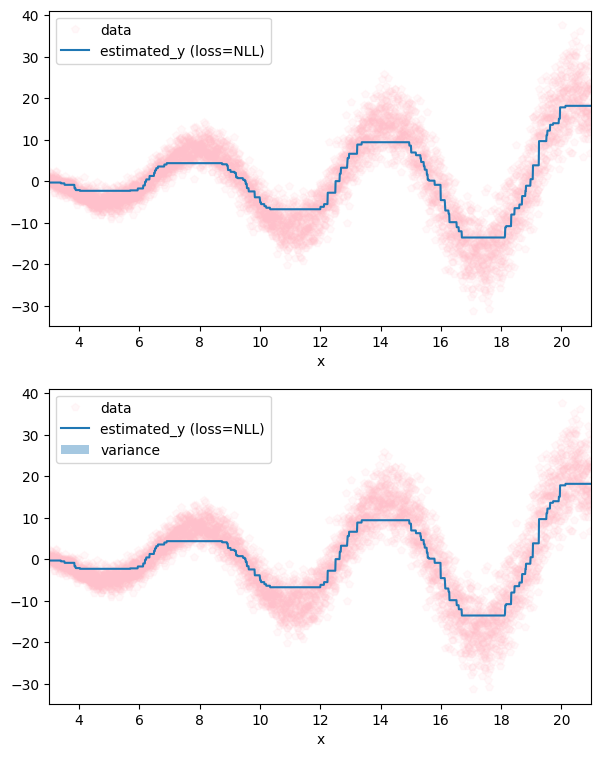

In [91]:
xlim = (xMin,xMax)
x_test = X_test.flatten()
y_pred = mean_prediction.numpy().flatten()
uncertainties = variance_prediction.numpy().flatten()

fig = plt.figure(figsize=(7,9))

ax = fig.add_subplot(2,1,1)
ax.plot(X_train,y_train,"p",alpha=0.1,c="pink",label="data")
ax.plot(x_test,y_pred,label="estimated_y (loss=NLL)")
ax.set_xlabel("x")
ax.set_xlim(*xlim)
ax.legend()

ax = fig.add_subplot(2,1,2)
ax.plot(X_train,y_train,"p",alpha=0.1,label="data",c="pink")
ax.plot(x_test,y_pred,label="estimated_y (loss=NLL)")
ax.fill_between(x_test, y_pred - uncertainties, y_pred + uncertainties, alpha = 0.4, label="variance")
ax.set_xlabel("x")
ax.set_xlim(*xlim)
ax.legend()
plt.show()